In [1]:
import spacy
import random
import pandas as pd
from spacy.gold import GoldParse
from spacy.scorer import Scorer
from tabulate import tabulate
import matplotlib.pyplot as plt

In [2]:
data_json = pd.read_json('../data/YungJunData/NLPoutput.json', lines = True)

In [3]:
data_json["content"] = data_json["content"].apply(lambda x: x.replace("\n", " "))
data_json["content"] = data_json["content"].apply(lambda x: x.lower())
data_json["content"].head(5)

0    Contact www.linkedin.com/in/hongong (LinkedIn)...
1    Contact www.linkedin.com/in/jun-wai- chin-Ob80...
2    Contact www.linkedin.com/in/mark-tan-bc (Linke...
3    Contact www.linkedin.com/in/lohys68 (LinkedIn)...
4    Contact www.linkedin.com/in/adi-zafri- bOba6a1...
Name: content, dtype: object

In [4]:
data_json["content"][0]

"Contact www.linkedin.com/in/hongong (LinkedIn) Top Skills High Performance Computing Operating Systems Fault Tolerance Languages Bahasa Melayu (Malay) (Limited Working) English (Full Professional) Chinese (Professional Working) Certifications Design Thinking Bootcamp Competing on Business Analytics and Big Data Hong H. Ong Head of Data Science and Analytics I Data Strategy, Innovation & Transformation I Build intelligent enterprise powered with data-driven analytics RLAthich Lumpur Summary I have two decades of data intensive computing experience. I am passionate about applying data strategy together with business driven technology to solve industrial problems. I have a strong record of success in leading, managing and delivering top tier innovative technology to align and achieve organisation needs and goals. I am currently the Head of Data Science and Analytics at Central Bank of Malaysia where I lead a team of data scientists and machine learning engineers responsible to provide ad

In [5]:
data_json.iloc[0].annotation

[{'label': ['Name'],
  'points': [{'start': 313, 'end': 324, 'text': 'Hong H. Ong'}]},
 {'label': ['CollegeName'],
  'points': [{'start': 6276,
    'end': 6300,
    'text': 'University of Portsmouth'}]},
 {'label': ['GraduationYear'],
  'points': [{'start': 6597, 'end': 6601, 'text': '2004'}]},
 {'label': ['YearsofExperience'],
  'points': [{'start': 2510, 'end': 2525, 'text': '1 year 4 months'}]},
 {'label': ['CompaniesWorkAt'],
  'points': [{'start': 2403,
    'end': 2448,
    'text': 'Central Banking Services Bank Negara Malaysia'}]},
 {'label': ['Email'],
  'points': [{'start': 8, 'end': 35, 'text': 'www.linkedin.com/in/hongong'}]},
 {'label': ['Location'],
  'points': [{'start': 2527, 'end': 2539, 'text': 'Kuala Lumpur'}]},
 {'label': ['Skills'],
  'points': [{'start': 58, 'end': 84, 'text': 'High Performance Computing'}]},
 {'label': ['Skills'],
  'points': [{'start': 85, 'end': 102, 'text': 'Operating Systems'}]},
 {'label': ['Skills'],
  'points': [{'start': 103, 'end': 118, 't

In [6]:
# import logging
import json
import re

# JSON formatting functions
def convert_dataturks_to_spacy(dataturks_JSON_FilePath):
    training_data = []
    lines=[]
    
    # read JSON file
    with open(dataturks_JSON_FilePath, encoding="utf8") as f:
        lines = f.readlines()

    for line in lines:
        data = json.loads(line)
        text = data['content'].replace("\n", " ") # remove next line
        entities = []
        data_annotations = data['annotation']
        if data_annotations is not None:
            for annotation in data_annotations:
                #only a single point in text annotation.
                point = annotation['points'][0]
                labels = annotation['label']
                
                # handle both list of labels or a single label.
                if not isinstance(labels, list):
                    labels = [labels]

                for label in labels:
                    point_start = point['start']
                    point_end = point['end']
                    point_text = point['text']

                    lstrip_diff = len(point_text) - len(point_text.lstrip())
                    rstrip_diff = len(point_text) - len(point_text.rstrip())
                    if lstrip_diff != 0:
                        point_start = point_start + lstrip_diff
                    if rstrip_diff != 0:
                        point_end = point_end - rstrip_diff
                    #dataturks indices are both inclusive [start, end] but spaCy is not 
                    entities.append((point_start, point_end + 1 , label)) 
        training_data.append((text, {"entities" : entities}))
    return training_data

def trim_entity_spans(data: list) -> list:
    """Removes leading and trailing white spaces from entity spans.

    Args:
        data (list): The data to be cleaned in spaCy JSON format.

    Returns:
        list: The cleaned data.
    """
    invalid_span_tokens = re.compile(r'\s')

    cleaned_data = []
    for text, annotations in data:
        entities = annotations['entities']
        valid_entities = []
        for start, end, label in entities:
            valid_start = start
            valid_end = end
            while valid_start < len(text) and invalid_span_tokens.match(
                    text[valid_start]):
                valid_start += 1
            while valid_end > 1 and invalid_span_tokens.match(
                    text[valid_end - 1]):
                valid_end -= 1
            valid_entities.append([valid_start, valid_end, label])
        cleaned_data.append([text, {'entities': valid_entities}])
    return cleaned_data

def to_lower(data):
    for i in range(len(data)):
        data[i][0] = data[i][0].lower()
    return data

In [7]:
data = trim_entity_spans(convert_dataturks_to_spacy("../NLPoutput.json"))
data = to_lower(data)
data[0]

["Contact www.linkedin.com/in/hongong (LinkedIn) Top Skills High Performance Computing Operating Systems Fault Tolerance Languages Bahasa Melayu (Malay) (Limited Working) English (Full Professional) Chinese (Professional Working) Certifications Design Thinking Bootcamp Competing on Business Analytics and Big Data Hong H. Ong Head of Data Science and Analytics I Data Strategy, Innovation & Transformation I Build intelligent enterprise powered with data-driven analytics RLAthich Lumpur Summary I have two decades of data intensive computing experience. I am passionate about applying data strategy together with business driven technology to solve industrial problems. I have a strong record of success in leading, managing and delivering top tier innovative technology to align and achieve organisation needs and goals. I am currently the Head of Data Science and Analytics at Central Bank of Malaysia where I lead a team of data scientists and machine learning engineers responsible to provide a

### Split into train and test data

In [13]:
train_data = data[:80]
test_data = data[-20:]

### Training

In [10]:
import warnings
from spacy.util import minibatch, compounding
# Number of Iteration 
no_itr = 150

#Create blank english model
nlp = spacy.blank('en') 

# Visualization
x_axis = []
y_axis = []

def train_model(train_data, test_data):
    
    # set up the pipeline
    if 'ner' not in nlp.pipe_names:
        ner = nlp.create_pipe('ner')
        nlp.add_pipe(ner, last = True) # ner component is added last in the pipeline (default).
        
    #add label
    for _, annotation in train_data:
        for ent in annotation['entities']:
            ner.add_label(ent[2]) #e.g. Location, Name... total 8
    
    # disable other pipeline components (tagger & parser) during training except ner
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
    with nlp.disable_pipes(*other_pipes), warnings.catch_warnings():
        warnings.filterwarnings("ignore", message=r"\[W030\]", category=UserWarning)
        
        optimizer = nlp.begin_training()
        
        for itn in range(no_itr):
            print("Starting iteration " + str(itn))
            random.shuffle(train_data)
            # This will ensure the model does not make generalizations based on the order of the train data.
            losses = {}
            
            batches = minibatch(train_data, size=compounding(4.0, 32.0, 1.001))
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(texts, annotations, sgd=optimizer, drop=0.2,
                           losses=losses)
                #dropout - prevent overfitting
            print('Losses', losses)
            y_axis.append(losses)
            x_axis.append(itn) 
    
    # Save model
    nlp.to_disk('nlp_model')
    print("Done updating spacy model...")

In [13]:
train_model(train_data, test_data)

/home/john/.virtualenvs/resume/lib/python3.7/site-packages/spacy/language.py:639: UserWarning: [W033] Training a new parser or NER using a model with an empty lexeme normalization table. This may degrade the performance to some degree. If this is intentional or this language doesn't have a normalization table, please ignore this warning.
  **kwargs
/home/john/.virtualenvs/resume/lib/python3.7/site-packages/spacy/language.py:639: UserWarning: [W034] Please install the package spacy-lookups-data in order to include the default lexeme normalization table for the language 'en'.
  **kwargs


Starting iteration 0
Losses {'ner': 10352.60327967961}
Starting iteration 1
Losses {'ner': 1917.7824279186316}
Starting iteration 2
Losses {'ner': 2006.4544007694349}
Starting iteration 3
Losses {'ner': 1858.4461970782722}
Starting iteration 4
Losses {'ner': 5226.999631678453}
Starting iteration 5
Losses {'ner': 3839.394824033603}
Starting iteration 6
Losses {'ner': 3619.1677800545003}
Starting iteration 7
Losses {'ner': 3515.9647508030757}
Starting iteration 8
Losses {'ner': 3115.2000612281263}
Starting iteration 9
Losses {'ner': 4633.185983255506}
Starting iteration 10
Losses {'ner': 4246.253510306822}
Starting iteration 11
Losses {'ner': 3135.5828370414674}
Starting iteration 12
Losses {'ner': 2265.460158109665}
Starting iteration 13
Losses {'ner': 2565.8377981265658}
Starting iteration 14
Losses {'ner': 3496.569674322498}
Starting iteration 15
Losses {'ner': 1881.2214275656443}
Starting iteration 16
Losses {'ner': 1503.6883390586736}
Starting iteration 17
Losses {'ner': 1120.248059

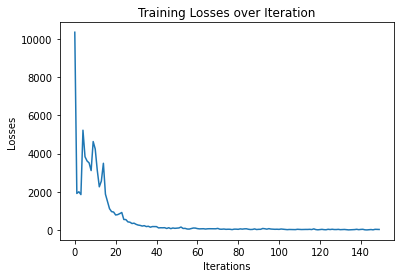

In [14]:
loss = []
for i in range(len(y_axis)):
    loss.append(y_axis[i]['ner'])
plt.plot(x_axis, loss)
plt.title("Training Losses over Iteration")
plt.xlabel("Iterations")
plt.ylabel("Losses")
plt.show()

### Test Trained Model

In [58]:
# # test the trained model
# for text, _ in test_data:
#     doc = nlp(text)
#     print('Entities', [(ent.text, ent.label_) for ent in doc.ents])
#     print('Tokens', [(t.text, t.ent_type_, t.ent_iob) for t in doc])

### Load the Model

In [11]:
nlp_model = spacy.load('nlp_model')

### Model Evaluation

In [14]:
#uas, las, tag_Acc are for Dependency parsing
def evaluate(nlp_model, test_data):
    counter = 0
    scorer = Scorer()
    for text, annot in test_data:
        doc_gold_text = nlp_model.make_doc(text)
        gold = GoldParse(doc_gold_text, entities=annot.get("entities"))
        pred_value = nlp_model(text)
        scorer.score(pred_value, gold)
        counter += 1
        #print(counter)
    return scorer.scores

results = evaluate(nlp_model, test_data)
results

/home/john/.virtualenvs/resume/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: [W030] Some entities could not be aligned in the text "Contact www.linkedin.com/in/muhammad- zamir-763232..." with entities "[[286, 300, 'Name'], [1507, 1532, 'CollegeName'], ...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities (with BILUO tag '-') will be ignored during training.
  import sys


{'uas': 0.0,
 'las': 0.0,
 'las_per_type': {'': {'p': 0.0, 'r': 0.0, 'f': 0.0}},
 'ents_p': 60.36585365853659,
 'ents_r': 60.0,
 'ents_f': 60.182370820668694,
 'ents_per_type': {'Skills': {'p': 64.15094339622641,
   'r': 66.66666666666666,
   'f': 65.38461538461539},
  'CompaniesWorkAt': {'p': 53.84615384615385,
   'r': 41.17647058823529,
   'f': 46.666666666666664},
  'GraduationYear': {'p': 33.33333333333333,
   'r': 35.294117647058826,
   'f': 34.285714285714285},
  'Name': {'p': 42.857142857142854, 'r': 33.33333333333333, 'f': 37.5},
  'YearsofExperience': {'p': 58.333333333333336,
   'r': 77.77777777777779,
   'f': 66.66666666666666},
  'Email': {'p': 86.66666666666667,
   'r': 86.66666666666667,
   'f': 86.66666666666667},
  'CollegeName': {'p': 76.92307692307693,
   'r': 58.82352941176471,
   'f': 66.66666666666667},
  'Location': {'p': 64.28571428571429, 'r': 75.0, 'f': 69.23076923076924}},
 'tags_acc': 0.0,
 'token_acc': 100.0,
 'textcat_score': 0.0,
 'textcats_per_cat': {}}

# Testing

In [18]:
def spacy_predict(text):
    test_doc = nlp_model(text) 
    s = ""
    for ent in test_doc.ents:
        s += f'{ent.label_.upper():{30}}- {ent.text}' + '\n'
    return test_doc, s

In [19]:
test_data[10]

["Contact www.linkedin.com/in/jim- looi-52313312 (LinkedIn) Top Skills Strategy Business Strategy Sales Process Languages English (Full Professional) Cantonese (Native or Bilingual) Chinese (Native or Bilingual) Mandarin (Native or Bilingual) Japanese (Elementary) Jim Looi Sales Manager at STMicroelectronics 6eiangoi Summary Involvie in daily operational and managing regional sales in Greater China and South East Asia, eg Shanghai, Shenzhen, Taipei, Penang, Singapore, Bangkok. Specialties: Fluent in both spoken and written English, Mandarin, Cantonese, and Malay. Fair in Japanese public speaking. Experience STMicroelectronics Sales Manager August 2005 - Present (16 years 5 months) * Reporting directly to Head of Department, whom reporting to CEO. * Managing a sales and customer service team of 6-8 persons located in Greater China and Asia Pacific. * Responsible for sales development in Electronic Manufacturing Services segment and distribution includes identifying new business opportun

In [20]:
test_doc, s = spacy_predict(test_data[18][0])
print(s)

EMAIL                         - www.linkedin.com/in/jimcarey
SKILLS                        - IT Service Management
SKILLS                        - Service Management
SKILLS                        - ITIL
COMPANIESWORKAT               - Prudential Services Asia 10 years
YEARSOFEXPERIENCE             - 4 years 3 months)
COLLEGENAME                   - Cardiff University / Prifysgol
GRADUATIONYEAR                - 1992)



In [21]:
spacy.displacy.render(test_doc, style='ent', jupyter=True)

In [22]:
test = "Contact www.linkedin.com/in/travis-leong- b2670775 (LinkedIn) Top Skills Management Project Management Business Process Improvement Travis Leong Application Support Manager at Focus Point Vision Care Group IVIalaysta Experience Focus Point Vision Care Group Application Support Manager Page 1 of 1"
test_doc, s = spacy_predict(test)
print (s)

EMAIL                         - www.linkedin.com/in/travis-leong- b2670775
SKILLS                        - Management
SKILLS                        - Project Management
SKILLS                        - Business Process Improvement
NAME                          - Travis Leong
COMPANIESWORKAT               - Focus Point Vision Care Group



In [25]:
test = "Contact www.linkedin.com/in/travis-leong- b2670775 (LinkedIn) Top Skills Management Project Management Business Process Improvement Travis Leong Application Support Manager at Focus Point Vision Care Group IVIalaysta Experience Focus Point Vision Care Group Application Support Manager Page 1 of 1"
test_doc, s = spacy_predict(test)
print (s)

EMAIL                         - www.linkedin.com/in/travis-leong- b2670775
SKILLS                        - Management
SKILLS                        - Project Management
SKILLS                        - Business Process Improvement
NAME                          - Travis Leong
COMPANIESWORKAT               - Focus Point Vision Care Group



In [26]:
# merged dataset
test = "Abhishek Jha Application Development Associate - Accenture  Bengaluru, Karnataka - Email me on Indeed: indeed.com/r/Abhishek-Jha/10e7a8cb732bc43a  • To work for an organization which provides me the opportunity to improve my skills and knowledge for my individual and company's growth in best possible ways.  Willing to relocate to: Bangalore, Karnataka  WORK EXPERIENCE  Application Development Associate  Accenture -  November 2017 to Present  Role: Currently working on Chat-bot. Developing Backend Oracle PeopleSoft Queries for the Bot which will be triggered based on given input. Also, Training the bot for different possible utterances (Both positive and negative), which will be given as input by the user.  EDUCATION  B.E in Information science and engineering  B.v.b college of engineering and technology -  Hubli, Karnataka  August 2013 to June 2017  12th in Mathematics  Woodbine modern school  April 2011 to March 2013  10th  Kendriya Vidyalaya  April 2001 to March 2011  SKILLS  C (Less than 1 year), Database (Less than 1 year), Database Management (Less than 1 year), Database Management System (Less than 1 year), Java (Less than 1 year)  ADDITIONAL INFORMATION  Technical Skills  https://www.indeed.com/r/Abhishek-Jha/10e7a8cb732bc43a?isid=rex-download&ikw=download-top&co=IN   • Programming language: C, C++, Java • Oracle PeopleSoft • Internet Of Things • Machine Learning • Database Management System • Computer Networks • Operating System worked on: Linux, Windows, Mac  Non - Technical Skills  • Honest and Hard-Working • Tolerant and Flexible to Different Situations • Polite and Calm • Team-Player"
test_doc, s = spacy_predict(test)
print (s)

SKILLS                        - Jha Application



In [27]:
test = "Abhishek Jha Application Development Associate - Accenture  Bengaluru, Karnataka - Email me on Indeed: indeed.com/r/Abhishek-Jha/10e7a8cb732bc43a  • To work for an organization which provides me the opportunity to improve my skills and knowledge for my individual and company's growth in best possible ways.  Willing to relocate to: Bangalore, Karnataka  WORK EXPERIENCE  Application Development Associate  Accenture -  November 2017 to Present  Role: Currently working on Chat-bot. Developing Backend Oracle PeopleSoft Queries for the Bot which will be triggered based on given input. Also, Training the bot for different possible utterances (Both positive and negative), which will be given as input by the user.  EDUCATION  B.E in Information science and engineering  B.v.b college of engineering and technology -  Hubli, Karnataka  August 2013 to June 2017  12th in Mathematics  Woodbine modern school  April 2011 to March 2013  10th  Kendriya Vidyalaya  April 2001 to March 2011  SKILLS  C (Less than 1 year), Database (Less than 1 year), Database Management (Less than 1 year), Database Management System (Less than 1 year), Java (Less than 1 year)  ADDITIONAL INFORMATION  Technical Skills  https://www.indeed.com/r/Abhishek-Jha/10e7a8cb732bc43a?isid=rex-download&ikw=download-top&co=IN   • Programming language: C, C++, Java • Oracle PeopleSoft • Internet Of Things • Machine Learning • Database Management System • Computer Networks • Operating System worked on: Linux, Windows, Mac  Non - Technical Skills  • Honest and Hard-Working • Tolerant and Flexible to Different Situations • Polite and Calm • Team-Player"
test_doc, s = spacy_predict(test)
print (s)

SKILLS                        - Jha Application



In [24]:
test = """Contact

www.linkedin.com/in/john-ooi- a593b145 (LinkedIn)

Top Skills Firewalls

Security TCP/IP

Certifications

Tellabs - Certificate of Achievement Tellabs Managed Edge System

Tellabs 8600 Hardware Interface Module Installation and Replacement Certification

Certified Information System Security Professional (CISSP)

Certified Penetration Testing Engineer

AlienVault Certified Security Engineer
John Ooi

Principal Security Consultant Seiangoi

Experience

SysArmy Sdn Bhd Principal Security Consultant November 2017 - Present (4 years 2 months)

PKF Malaysia Senior Security Consultant November 2016 - October 2017 (1 year)

e-Cop Surveillance Sdn Bhd Security Consultant November 2012 - October 2016 (4 years)

* Supporting various of Managed Security Service clients.
* Work closely with SOC team to provide 2nd level of support.
* Involved in pre-sales activities for market leading ICT security solutions such as IFS, APT, SIEM etc.
* Provision of Technical Pre-sales and Post-Sales support to assigned

accounts (Financial Service Sector) * Preparation of Technical Proposals, Tender Documentation, Presentations, Technical Briefings and follow-up discussion, implementation and review * Preparation of Monthly Security Incident Reports and Presentation * Liaising with clients/users with regards to security incident reports and

handling * Provision of Advisories and Technical Recommendations to clients to enhance security network posture, controls, policies, processes and practices.
* Propose technical solutions and functional consultation and support in project implementation with excellent customer service skills.
* Provide guidance to Security Engineer in project implementation & troubleshooting.
* Involve in operational services: security compliance, gap analysis, risk management, resource violation and external gateways perimeter review.

AT&T Communication Services Project Validation & Guidance Coordinator April 2011 - November 2012 (1 year 8 months)

Page 1 of 2
 
Diversified Gateway Berhard Network Support Engineer March 2009 - April 2011 (2 years 2 months)

Satyam Computer Services Ltd Network & System Support Engineer July 2007 - March 2009 (1 year 9 months)

Education

Universiti Putra Malaysia Computer Science, Networking

Page 2 of 2"""
test_doc, s = spacy_predict(test)
print (s)

SKILLS                        - Firewalls
NAME                          - Tellabs Managed
YEARSOFEXPERIENCE             - 4 years 2 months)
GRADUATIONYEAR                - 2007 -
COMPANIESWORKAT               - Universiti Putra Malaysia



In [23]:
test = "kuala lumpur johor bahru"
test_doc, s = spacy_predict(test)
print (s)